## Calculate percent replicating for cell painting data

* Subsampled to have the same number of replicates as L1000
* Non-spherized (median) normalization

Code modified from @adeboyeML

In [1]:
import re
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_context("talk")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
dose_recode_info = {
    1: '0.04 uM', 2:'0.12 uM', 3:'0.37 uM',
    4: '1.11 uM', 5:'3.33 uM', 6:'10 uM'
}

In [3]:
results_dir = pathlib.Path("../results")
cp_level4_path = 'cellpainting_lvl4_cpd_replicate_datasets'

file_indicator = "nonspherized"

In [4]:
df_cpd_median_scrs = pd.read_csv(os.path.join(cp_level4_path, f'cpd_replicate_median_scores_{file_indicator}.csv'))
df_null_p_vals = pd.read_csv(os.path.join(cp_level4_path, f'cpd_replicate_p_values_{file_indicator}.csv'))

In [5]:
# Common compounds
common_file = pathlib.Path("..", "..", "..", "6.paper_figures", "data", "significant_compounds_by_threshold_both_assays.tsv.gz")
common_df = pd.read_csv(common_file, sep="\t")

common_compounds = common_df.compound.unique()
print(len(common_compounds))

1327


In [6]:
# Subset to common compound measurements
df_cpd_median_scrs = df_cpd_median_scrs.loc[df_cpd_median_scrs.cpd.isin(common_compounds), :]

In [7]:
df_level4 = pd.read_csv(os.path.join(cp_level4_path, f'cp_level4_cpd_replicates_{file_indicator}.csv.gz'), 
                        compression='gzip',low_memory = False)

with open(os.path.join(cp_level4_path, f'null_distribution_{file_indicator}.pickle'), 'rb') as handle:
    null_distribution_replicates = pickle.load(handle)
    
with open(os.path.join(cp_level4_path, f'null_dist_medians_per_dose_{file_indicator}.pickle'), 'rb') as handle:
    null_dist_med_cp = pickle.load(handle)

In [8]:
df_all_scores = pd.read_csv(os.path.join(cp_level4_path, f'cp_all_scores_{file_indicator}.csv'))

In [9]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.rename(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

In [10]:
df_cpd_median_scores = rename_cols(df_cpd_median_scrs.copy()).rename(columns={"cpd_size": "no_of_replicates"})
df_null_p_vals = rename_cols(df_null_p_vals)

In [11]:
def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    df = df.melt(id_vars=['cpd', 'no_of_replicates'], var_name="dose", value_name=col_name)
    return df

In [12]:
def merge_p_median_vals(df_cpd_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each compound for all doses(1-6) 
    """
    df_p_vals = melt_df(df_null, 'p_values')
    df_cpd_vals = melt_df(df_cpd_vals, 'median_scores')
    df_cpd_vals['p_values'] = df_p_vals['p_values']
    return df_cpd_vals

In [13]:
def plot_p_vs_median(df, path, file_name):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs median scores for compound replicates")
    fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
                          style="dose", palette = "viridis")
    fig.axhline(0.05, ls='--', c='black')
    fig.legend(loc = 'upper right')
    fig.text(-0.18,0.07, "Significance level (0.05)")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

In [14]:
df_medians_p_vals = merge_p_median_vals(df_cpd_median_scores, df_null_p_vals)
df_medians_p_vals.head()

,cpd,no_of_replicates,dose,median_scores,p_values
0,17-hydroxyprogesterone-caproate,5,0.04 uM,0.511133,0.000
1,2-iminobiotin,5,0.04 uM,0.123800,0.188
2,3-amino-benzamide,5,0.04 uM,0.421004,0.003
3,3-deazaadenosine,5,0.04 uM,0.077982,0.310
4,ABT-737,5,0.04 uM,0.265878,0.021


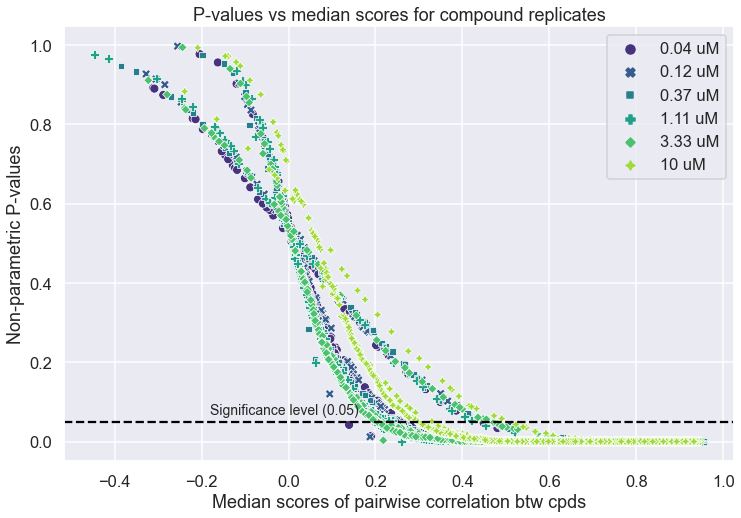

In [15]:
plot_p_vs_median(df_medians_p_vals, 'cellpainting_figures', f'p_vs_median_{file_indicator}.png')

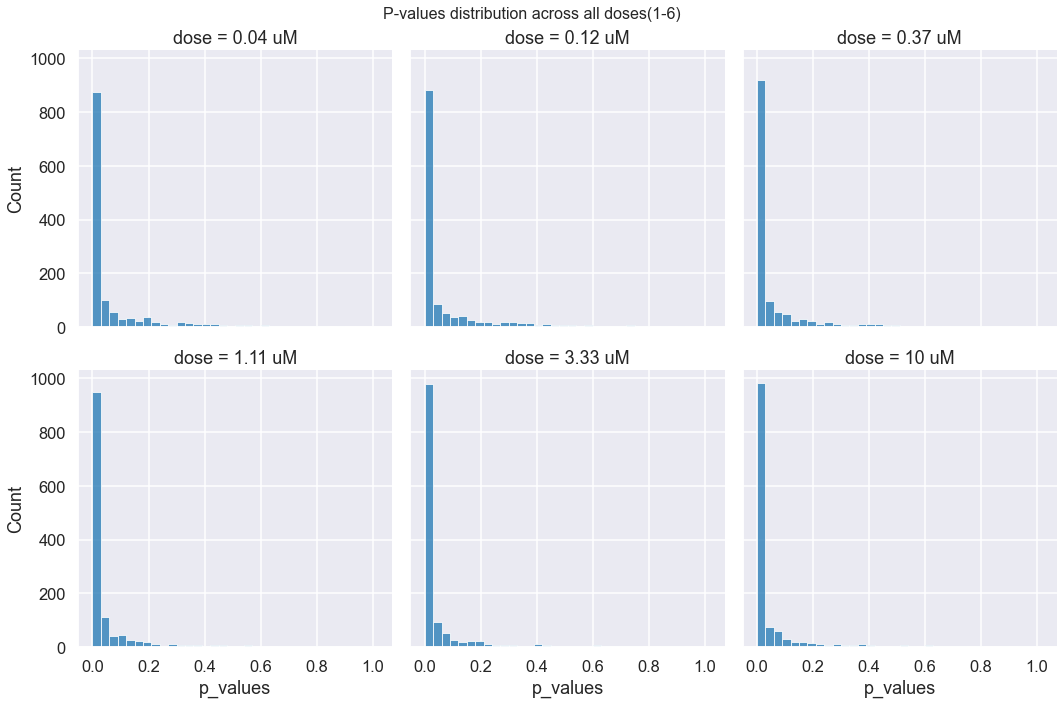

In [16]:
def plot_p_value_dist(df, path, file_name):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    dis_plt = sns.displot(df, x="p_values", col="dose", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle("P-values distribution across all doses(1-6)", size = 16)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_p_value_dist(df_medians_p_vals, 'cellpainting_figures', f'p_value_distribution_{file_indicator}.png')

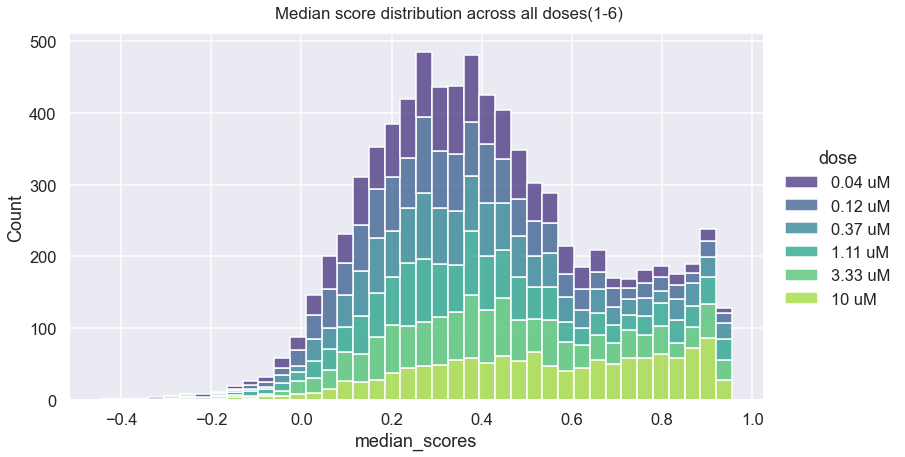

In [17]:
def plot_median_score_distribution(df, title, path, file_name):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x="median_scores", hue="dose", kind="hist", 
                          multiple="stack", palette = 'viridis', height=6.5, aspect=1.7)
    dis_plt.fig.suptitle(title)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_median_score_distribution(df_medians_p_vals, "Median score distribution across all doses(1-6)",
                               'cellpainting_figures', f'median_score_distribution_{file_indicator}.png')

In [18]:
def get_replicate_score(cpds_list, df):
    
    """
    This function computes the spearman replicate correlation scores 
    between replicates for all compounds
    """
    cpds_replicate_score = []
    for cpd in cpds_list:
        cpd_replicates = df[df['pert_iname'] == cpd].copy()
        cpd_replicates.drop(['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_dose_recode', 'Metadata_Plate', 
                             'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 'broad_id', 
                             'pert_iname', 'moa', 'replicate_name'], axis = 1, inplace = True)
        cpd_replicates_corr = cpd_replicates.astype('float64').T.corr(method = 'spearman').values
        cpds_replicate_score += list(cpd_replicates_corr[np.triu_indices(len(cpd_replicates_corr), k = 1)])
    return cpds_replicate_score

In [19]:
def get_true_replicate_score(df, df_lvl4):
    
    """This function gets the true spearman percentile correlation scores for all compounds across all doses (1-6)"""
    
    dose_list = list(set(df_lvl4['Metadata_dose_recode'].unique().tolist()))[1:7]
    cpd_sizes =  df['no_of_replicates'].unique().tolist()
    df = df.set_index('cpd').rename_axis(None, axis=0)
    true_replicates = {}
    for dose in dose_list:
        rep_list = []
        df_dose = df_lvl4[df_lvl4['Metadata_dose_recode'] == dose].copy()
        for keys in cpd_sizes:
            cpds_keys = df[df['no_of_replicates'] == keys].index
            replicates_vals = get_replicate_score(cpds_keys, df_dose)
            rep_list += replicates_vals
        true_replicates[dose] = rep_list
    return true_replicates

In [20]:
true_replicates = get_true_replicate_score(df_cpd_median_scores, df_level4)

In [21]:
def get_random_replicate_score(random_rep_list, df):
    
    """This function computes the spearman correlation scores between random replicates"""
    
    df_dose_ = df.set_index('replicate_name').rename_axis(None, axis=0)
    df_dose_.drop(['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_dose_recode', 'Metadata_Plate', 
                   'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 
                   'broad_id', 'pert_iname', 'moa'], axis = 1, inplace = True)
    rep_corr_list = []
    for rep_list in random_rep_list:
        df_reps = df_dose_.loc[rep_list].copy()
        reps_corr = df_reps.astype('float64').T.corr(method = 'spearman').values
        rep_corr_list += list(reps_corr[np.triu_indices(len(reps_corr), k = 1)])
    return rep_corr_list

In [22]:
def get_rand_replicate_corr(df_lvl4, null_dist):
    """
    This function gets spearman correlation values 
    between randomly selected replicates across all doses (1-6)
    
    Returns a dictionary, with the dose number as the keys and 
    all the correlation scores between randomly selected replicates 
    as the values
    """
    dose_list = list(set(df_lvl4['Metadata_dose_recode'].unique().tolist()))[1:7]
    random_replicates = {}
    for dose in dose_list:
        rep_list = []
        df_dose = df_lvl4[df_lvl4['Metadata_dose_recode'] == dose].copy()
        for key in null_dist:
            rand_rep_list = null_dist[key][dose-1]
            rep_list += get_random_replicate_score(rand_rep_list, df_dose)
        random_replicates[dose] = rep_list
    return random_replicates

In [23]:
random_replicates = get_rand_replicate_corr(df_level4, null_distribution_replicates)

In [24]:
def transform_dataframe(rep, rep_name):
    """
    Transforms replicate correlation dataframe to have 3 columns: 
    dose, correlation_values and type of replicates
    """
    df_reps = pd.DataFrame.from_dict(rep, orient='index').T
    rep_melt = df_reps.melt(var_name="dose", value_name="correlation_values")
    rep_melt['type'] = rep_name
    return rep_melt

In [25]:
df_true_rep = transform_dataframe(true_replicates, 'true replicate')
df_rand_rep = transform_dataframe(random_replicates, 'non replicate')

In [26]:
null_percent_replicating_score_df = transform_dataframe(null_dist_med_cp, "non_replicate").assign(assay="Cell Painting")
null_percent_replicating_score_df.dose = null_percent_replicating_score_df.dose.replace(dose_recode_info)

output_file = pathlib.Path(f"{results_dir}/cell_paintint_percent_replicating_data_null_distribution_{file_indicator}.tsv.gz")
null_percent_replicating_score_df.to_csv(output_file, sep="\t", index=False)

print(null_percent_replicating_score_df.shape)
null_percent_replicating_score_df.head()

(24000, 4)


,dose,correlation_values,type,assay
0,0.04 uM,0.233114,non_replicate,Cell Painting
1,0.04 uM,-0.029854,non_replicate,Cell Painting
2,0.04 uM,-0.004535,non_replicate,Cell Painting
3,0.04 uM,0.063295,non_replicate,Cell Painting
4,0.04 uM,-0.139619,non_replicate,Cell Painting


In [27]:
def plot_replicate_vs_non_replicate(df_true, df_rand, title, path, file_name):
    """Plot replicate vs non-replicate correlation values distribution across all doses"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    fig, axes = plt.subplots(ncols=3, nrows=2)
    fig.set_size_inches(18.7, 12.27)
    labels = ['Non-replicate', 'Replicate']
    
    for i, ax in zip(range(1,7), axes.flat):
        sns.distplot(df_rand[df_rand['dose'] == i]["correlation_values"], hist=True,ax=ax)
        sns.distplot(df_true[df_true['dose'] == i]["correlation_values"], hist=True,ax=ax)
        ax.legend(labels, loc="upper right", fontsize='small')
        
    [axes[0][idx].set_title("Dose = " + dose) for idx, dose in enumerate(['0.04 uM', '0.12 uM', '0.37 uM'])]
    [axes[1][idx].set_title("Dose = " + dose) for idx, dose in enumerate(['1.11 uM', '3.33 uM', '10 uM'])]
    [axes[0][i].set_xlabel("") for i in range(0, 3)]
    [axes[0][i].set_ylabel("") for i in range(1, 3)]
    [axes[1][i].set_ylabel("") for i in range(1, 3)]
    fig.suptitle(title)
    fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()

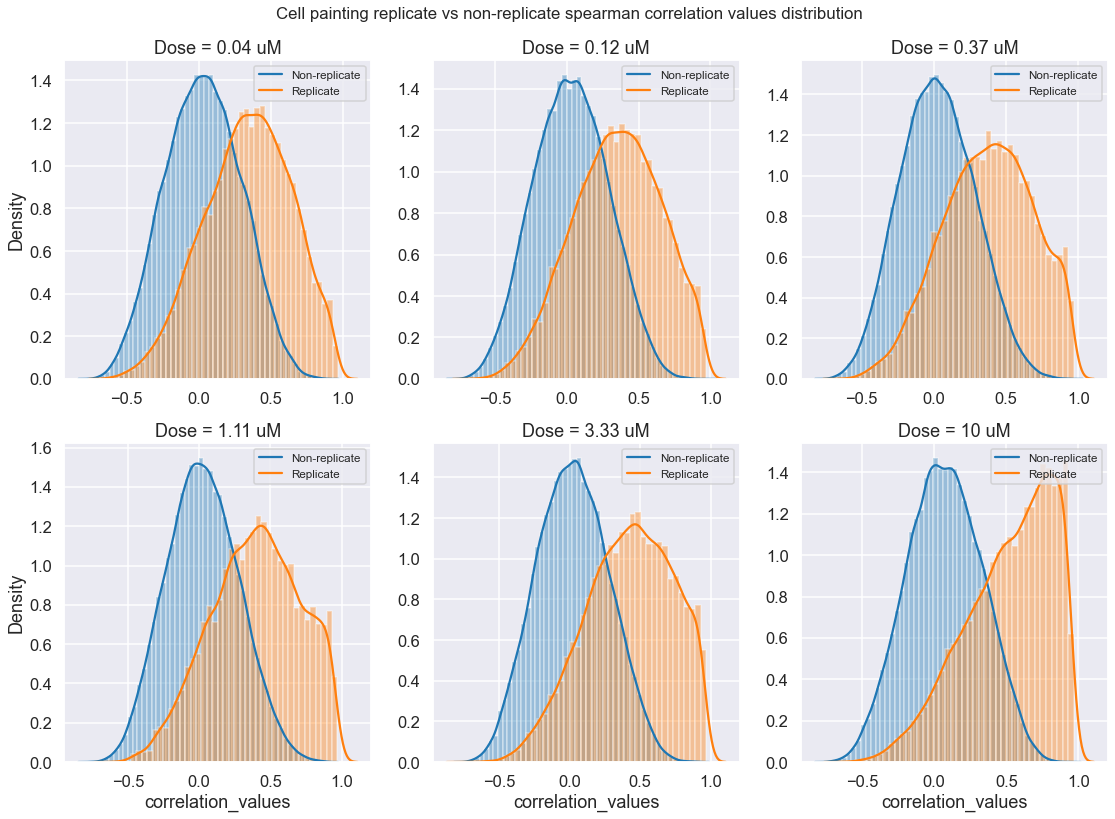

In [28]:
plot_replicate_vs_non_replicate(df_true_rep, df_rand_rep, 
                                "Cell painting replicate vs non-replicate spearman correlation values distribution", 
                                'cellpainting_figures', f'replicate_non_replicate_dist_{file_indicator}.png')

In [29]:
full_cor_df = pd.concat([df_true_rep, df_rand_rep], axis="rows").reset_index(drop=True).dropna()

full_cor_df.dose = full_cor_df.dose.replace(dose_recode_info)

print(full_cor_df.shape)

output_file = pathlib.Path(f"{results_dir}/cell_painting_pairwise_correlation_distribution_{file_indicator}.tsv.gz")
full_cor_df.to_csv(output_file, sep="\t", index=False)

(448196, 3)


In [30]:
def reproducible_dose(df):
    """
    This function computes how many doses each compound 
    has reproducible median correlation score in, (out of the 6 doses based on p values)
    """
    df_new = df.set_index('cpd').rename_axis(None, axis=0).drop(['no_of_replicates'], axis = 1).copy()
    cpd_values = {cpd:sum(df_new.loc[cpd] <= 0.05) for cpd in df_new.index}
    df['No_of_reproducible_doses'] = cpd_values.values()
    
    return df

In [31]:
df_cp_pvals = reproducible_dose(df_null_p_vals)
df_all_scores = df_all_scores.merge(df_cp_pvals[['cpd', 'no_of_replicates', 'No_of_reproducible_doses']], on=['cpd'])

In [32]:
output_file = pathlib.Path(f"{results_dir}/cell_painting_percent_replicating_data_{file_indicator}.tsv.gz")
df_all_scores.to_csv(output_file, sep="\t", index=False)

print(df_all_scores.shape)
df_all_scores.head()

(7962, 7)


,cpd,dose,replicate_correlation,signature_strength,MAS,no_of_replicates,No_of_reproducible_doses
0,17-hydroxyprogesterone-caproate,0.04 uM,0.511133,247.8,0.412325,5,6
1,17-hydroxyprogesterone-caproate,0.12 uM,0.329249,280.2,0.351899,5,6
2,17-hydroxyprogesterone-caproate,0.37 uM,0.224179,333.8,0.316929,5,6
3,17-hydroxyprogesterone-caproate,1.11 uM,0.287033,264.4,0.319167,5,6
4,17-hydroxyprogesterone-caproate,3.33 uM,0.325092,274.2,0.345907,5,6
